In [ ]:
# default_exp sine_model

In [ ]:
#hide 
%load_ext autoreload
%autoreload 2

In [ ]:
#export
from rtma.imports import *
from rtma.core import *
from rtma.signal import *
from rtma.fft import *
from rtma.stft import *

# Sine Model

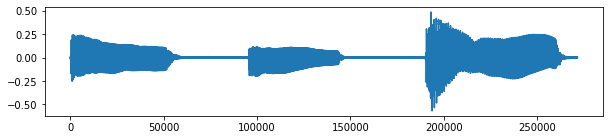

In [ ]:
fn = "data/E_octaves_both.wav"
x, sr = load_audio(fn)
plot(x)

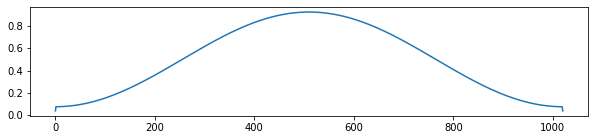

In [ ]:
n_fft = 1024
h = 510
m = h*2 + 1
wn = 'hamming'
w = get_cola_window('hamming', m, h)
plot(w)

In [ ]:
spectrum = list(stft(x, n_fft, h, w))
mx, px = (np.stack(s) for s in zip(*spectrum))
mx = 20*np.log10(mx)
print(f'n_fft: {n_fft}, m: {m}, h: {h}, w: {wn}')
mx.shape, px.shape

n_fft: 1024, m: 1021, h: 510, w: hamming


((534, 513), (534, 513))

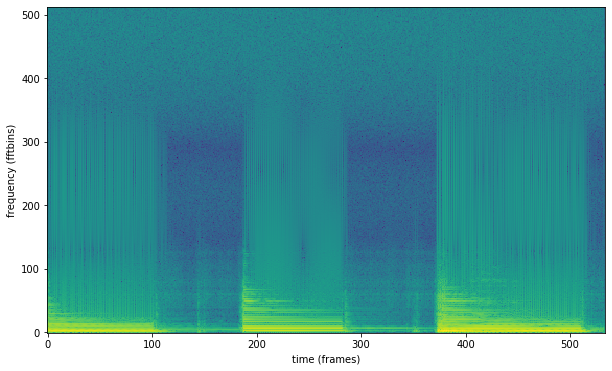

In [ ]:
plot_mags(mx)

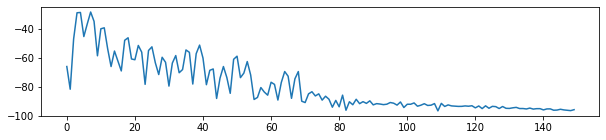

In [ ]:
frame_i = 200
mags = mx[frame_i]
plot(mags[:150])

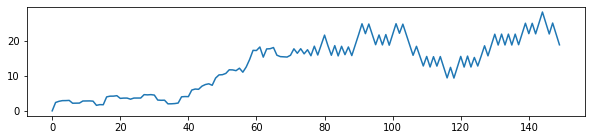

In [ ]:
phases = px[frame_i]
plot(phases[:150])

## Peak Detection

In [ ]:
#export
def detect_peaks(x, thresh):
    # first and last cannot be peaks
    above_thresh = np.greater(x[1:-1], thresh)
    gt_before = np.greater(x[1:-1], x[:-2])
    gt_after =  np.greater(x[1:-1], x[2:])
    is_peak = above_thresh & gt_before & gt_after
    peaks_i = is_peak.nonzero()[0] + 1
    return peaks_i 

In [ ]:
arr = np.array([2, 10, 3, 8, -2, 3, 1, 9, 0, 2, 1])
assert np.array_equal(detect_peaks(arr, 1), [1,3,5,7,9])
assert np.array_equal(detect_peaks(arr, 2), [1,3,5,7])
assert np.array_equal(detect_peaks(arr, 3), [1,3,7])

In [ ]:
#export
def plot_peaks(x, peak_i, t=None):
    plt.figure(figsize=(10, 6))
    plt.plot(x)
    plt.plot(peak_i, x[peak_i], marker='x', color='r', linestyle='', markeredgewidth=1.5)
    if t is not None:
        plt.axhline(t, c='g')

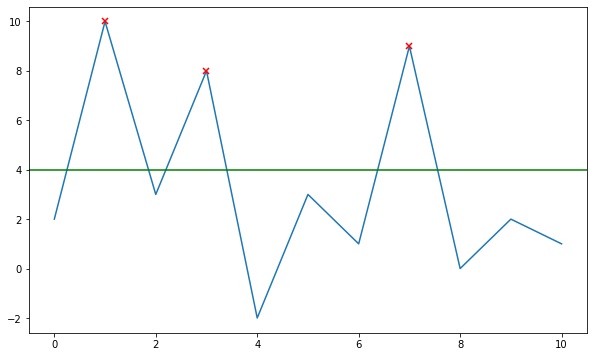

In [ ]:
t = 4
plot_peaks(arr, detect_peaks(arr, t), t)

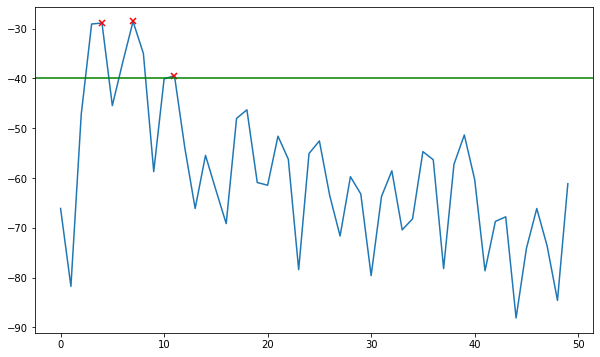

In [ ]:
t = -40
peak_i = detect_peaks(mags, t)[:10]
plot_peaks(mags[:50], peak_i, t)

## Peak Interpolation

In [ ]:
#export
def interpolate_peaks(mags, peak_i):
    a, b, c = mags[peak_i-1], mags[peak_i], mags[peak_i+1]
    ipeak_i = peak_i + 0.5 * (a - c) / (a - 2*b + c)
    ipeak_mags = b - 0.25 * (a - c) * (ipeak_i - peak_i)
    return ipeak_i, ipeak_mags

In [ ]:
#export
def plot_ipeaks(mags, ipeak_i, ipeak_mag, peak_i=None, t=None):
    plt.figure(figsize=(10, 6))
    plt.plot(mags)
    plt.plot(ipeak_i, ipeak_mag, marker='x', color='g', linestyle='', markeredgewidth=1.5)
    if peak_i is not None:
        plt.plot(peak_i, mags[peak_i], marker='x', color='r', linestyle='', markeredgewidth=1.5)
    if t is not None:
        plt.axhline(t, c='g')

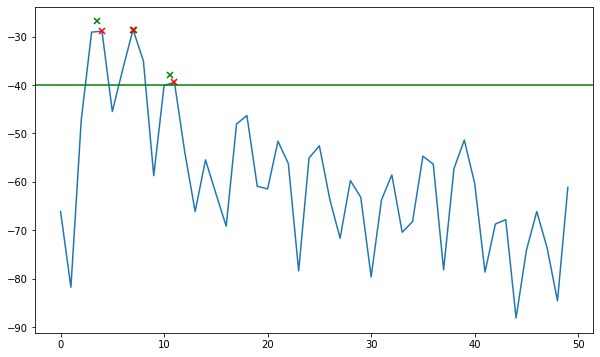

In [ ]:
ipeak_i, ipeak_mag = interpolate_peaks(mags, peak_i)
plot_ipeaks(mags[:50], ipeak_i, ipeak_mag, peak_i=peak_i, t=t)

In [ ]:
ipeak_freq = sr * ipeak_i / n_fft
ipeak_freq

array([164.61361836, 331.0181719 , 494.25827267])

In [ ]:
idx = np.arange(phases.size)
ipeak_phase = np.interp(ipeak_i, idx, phases)
ipeak_phase

array([2.928796  , 2.19993749, 2.83588188])

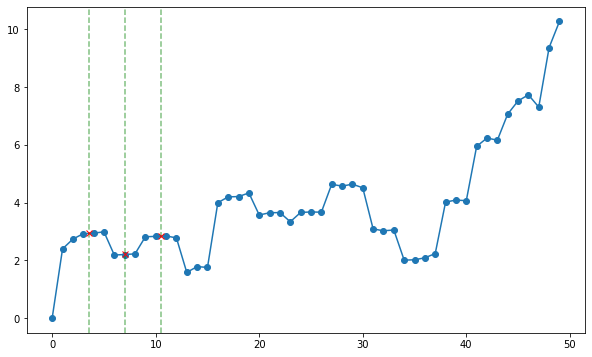

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(idx[:50], phases[:50], marker='o')
for i in ipeak_i:
    plt.axvline(i, c='g', linestyle='--', alpha=0.5)
plt.plot(ipeak_i, ipeak_phase, c='r', linestyle='', marker='x')

## Synthesis

In [ ]:
def sinc(x, N):
    y = np.sin(N * x/2) / np.sin(x/2)                  # compute the sinc function
    y[np.isnan(y)] = N                                 # avoid NaN if x == 0
    return y

def genBhLobe(x, N=512):
    f = x*np.pi*2/N                                         # frequency sampling
    df = 2*np.pi/N
    y = np.zeros(x.size)                                    # initialize window
    consts = [0.35875, 0.48829, 0.14128, 0.01168]           # window constants
    for m in range(0,4):                                    # iterate over the four sincs to sum
        y += consts[m]/2 * (sinc(f-df*m, N) + sinc(f+df*m, N))  # sum of scaled sinc functions
    y = y/N/consts[0]                                       # normalize
    return y

/home/john/miniconda3/envs/rtma/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


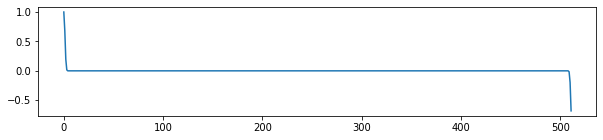

In [ ]:
a = np.arange(512)
plot(genBhLobe(a))

In [ ]:
def generate_sine_spectrum(ipeak_f, ipeak_m, ipeak_p, N, fs):
    Y = np.zeros(N, dtype=np.complex64)
    hN = N//2
    
    ipeak_i = ipeak_f * N / fs
    assert (ipeak_i > 0).all()  # not sure 
    assert (ipeak_i <= hN).all(), f'{ipeak_i.max(), hN}'
    
    for i, mag, phase in zip(ipeak_i, ipeak_m, ipeak_p):
        bin_remainder = round(i) - i
        lb = np.arange(bin_remainder-4, bin_remainder+5)
        lmag = genBhLobe(lb) * 10**(mag/20)
        bs = np.arange(round(i) - 4, round(i) + 5, dtype=int)        
        for m, b in enumerate(bs):
            if b < 0:      # lobe crosses DC
                Y[-b] += lmag[m]*np.exp(-1j*phase)
            
            elif b > hN:   # lobe crosses nyquist
                Y[b] += lmag[m] * np.exp(-1j*phase)
            
            elif b == 0 or b == hN:   #limits of spectrum
                Y[b] += lmag[m]*np.exp(1j*phase) + lmag[m]*np.exp(-1j*phase)
            
            else:  # pos freq range
                Y[b] += lmag[m]*np.exp(1j*phase)
            
        Y[hN+1:] = Y[hN-1:0:-1].conjugate()
    return Y
            

Y = generate_sine_spectrum(ipeak_freq, ipeak_mag, ipeak_phase, n_fft, sr)

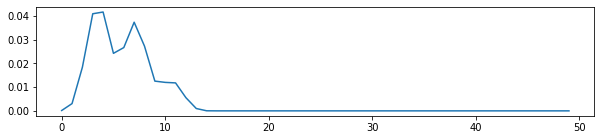

In [ ]:
plot(abs(Y)[:50])

### blackman window..

In [ ]:
bh = genBhLobe(np.arange(6))
bh[:6]

/home/john/miniconda3/envs/rtma/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


array([ 1.00000000e+00,  6.80543554e-01,  1.96905923e-01,  1.62787456e-02,
       -6.50095043e-21,  6.50131411e-21])

In [ ]:
m = 512
bh = get_window('blackmanharris', m)
bh /= bh.sum()
bhm, bhp = fft_analysis(bh, m)
bhm[:6]

array([1.00000000e+00, 6.80543554e-01, 1.96905923e-01, 1.62787456e-02,
       4.52955313e-18, 1.92231474e-17])

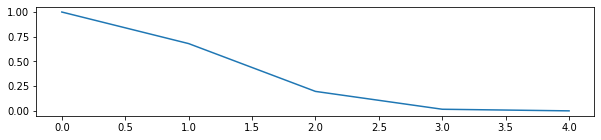

In [ ]:
plot(bhm[:5])

## sineModel

In [ ]:
x, sr = load_audio(fn)
n_fft = 2048
m = 1001
h = 512
t = -80
w = get_cola_window('hamming', n_fft, h)

In [ ]:
w.sum()

512.0

In [ ]:
from scipy.signal import blackmanharris, triang

In [ ]:
#export
def synth_window(n_fft: int) -> np.ndarray:
    h = n_fft // 4
    t_win = triang(2 * h)
    t_win = np.pad(t_win, (h, h), mode='constant')
    bh_win = blackmanharris(n_fft)
    bh_win /= bh_win.sum()
    win = t_win / bh_win
    return win

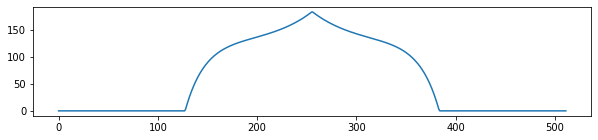

In [ ]:
sw = synth_window(512)
plot(sw)

In [ ]:
sw.sum()

31544.949755809088

In [ ]:
def sine_model(x, fs, w, n_fft, t):
    n_fft_synth = 512
    h = n_fft_synth // 4
    
    sw = synth_window(n_fft_synth)

    frames = []
    for mx, px in stft(x, n_fft, h, w):
        mx_db = 20 * np.log10(mx)
        
        peak_i = detect_peaks(mx_db, t)
        ipeak_i, ipeak_m = interpolate_peaks(mx_db, peak_i)
        ipeak_p = np.interp(ipeak_i, np.arange(px.size), px)
        ipeak_f = fs * ipeak_i / n_fft
        
        Y = generate_sine_spectrum(ipeak_f, ipeak_m, ipeak_p, n_fft_synth, fs)
        fft_buffer = np.real(np.fft.ifft(Y))
        yw = zero_phase_buffer(fft_buffer, n_window=n_fft_synth, reverse=True)        
        frames.append(sw*yw)
        
    return synth_frames(frames, h, x.size)

In [ ]:
x.shape, w.shape, n_fft, t, sr

((271522,), (2048,), 2048, -80, 48000)

In [ ]:
w.sum()

512.0

In [ ]:
%%time

y = sine_model(x, sr, w, n_fft, t)

CPU times: user 5.13 s, sys: 15 ms, total: 5.15 s
Wall time: 5.15 s


In [ ]:
# 4.35s to generate a 5.66s sound

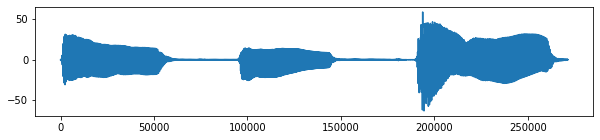

In [ ]:
plot(y)

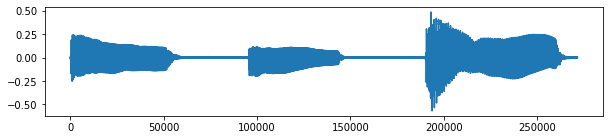

In [ ]:
plot(x)

In [ ]:
import IPython.display as ipd

In [ ]:
ipd.display(ipd.Audio(x, rate=sr))

In [ ]:
ipd.display(ipd.Audio(y, rate=sr))

## Sine Model Analysis

In [ ]:
#export
class Frame:
    def __init__(self, freqs=None, mags=None, phases=None):
        self.freqs = freqs
        self.mags = mags
        self.phases = phases
    
    def __len__(self):
        return self.freqs.size

In [ ]:
#export
def sine_model_analysis(x, fs, w, n_fft, h, t):
    frames = []
    for frame_i, (mx, px) in enumerate(stft(x, n_fft, h, w)):
        mx_db = 20.0 * np.log10(mx)        
        peak_i = detect_peaks(mx_db, t)
        ipeak_i, ipeak_m = interpolate_peaks(mx_db, peak_i)
        ipeak_p = np.interp(ipeak_i, np.arange(px.size), px)
        ipeak_f = fs * ipeak_i / n_fft

        frame = Frame(ipeak_f, ipeak_m, ipeak_p)
        frames.append(frame)
        
    return frames

In [ ]:
%%time

frames = sine_model_analysis(x, sr, w, n_fft, h, t)
len(frames)

CPU times: user 85 ms, sys: 185 µs, total: 85.1 ms
Wall time: 84.8 ms


534

In [ ]:
#export
def synth_window(n_fft: int, h: int) -> np.ndarray:
    t_win = triang(2 * h)
    padding = (n_fft - 2*h) // 2
    t_win = np.pad(t_win, (padding, padding), mode='constant')
    bh_win = blackmanharris(n_fft)
    bh_win /= bh_win.sum()
    win = t_win / bh_win
    return win

In [ ]:
#export
def sine_model_synthesis(frames, n_fft, h, fs):
    n_frames = len(frames)
    y_length = h*(n_frames - 1) + n_fft
    y = np.zeros(y_length)
    
    synth_win = synth_window(n_fft, h)    

    for i, f in enumerate(frames):        
        Y = generate_sine_spectrum(f.freqs, f.mags, f.phases, n_fft, fs)        
        fft_buffer = np.real(np.fft.ifft(Y))
        yw = zero_phase_buffer(fft_buffer, n_window=n_fft, reverse=True)   
        offset = i*h
        y[offset:offset+n_fft] += synth_win * yw
        
    return y
        

In [ ]:
%%time

sr1 = sr
y = sine_model_synthesis(frames, 4096, 512, sr1)

y = y[2048-512:]
y = y[:x.size]
y.max()

CPU times: user 374 ms, sys: 0 ns, total: 374 ms
Wall time: 374 ms


0.4551627438172215

In [ ]:
ipd.display(ipd.Audio(y, rate=sr1))
y.shape

(271522,)

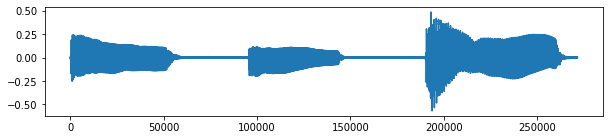

In [ ]:
plot(x)

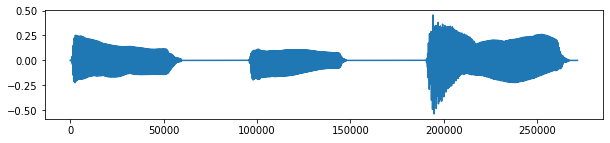

In [ ]:
plot(y)

## All together

In [ ]:
x, sr = load_audio(fn)
n_fft = 2048
m = 1001
h = 512
t = -50
w = get_cola_window('hamming', n_fft, h)
frames = sine_model_analysis(x, sr, w, n_fft, h, t)
len(frames)

534

In [ ]:
y = sine_model_synthesis(frames, 2048, 512, sr1)

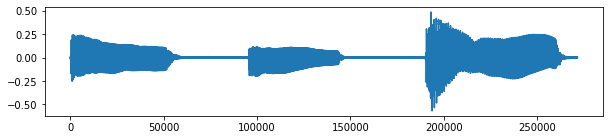

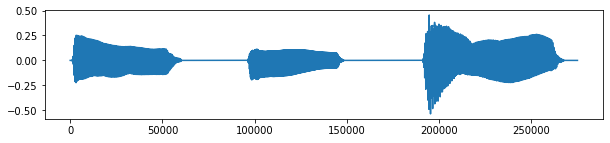

In [ ]:
plot(x)
plot(y)

### sine_tracking

In [ ]:
[len(f) for f in frames[:10]]

[0, 2, 6, 9, 8, 8, 8, 8, 7, 7]

In [ ]:
np.set_printoptions(precision=2)

In [ ]:
[f.freqs[:5] for f in frames[:10]]

[array([], dtype=float64),
 array([160.92, 262.47]),
 array([161.54, 251.95, 335.58, 497.67, 581.34]),
 array([ 82.29, 164.09, 247.21, 333.84, 416.66]),
 array([ 82.69, 165.38, 245.01, 329.28, 495.67]),
 array([ 82.63, 164.92, 245.32, 329.01, 495.63]),
 array([ 82.38, 165.23, 245.78, 329.24, 495.62]),
 array([ 82.22, 165.47, 246.31, 328.87, 495.75]),
 array([ 82.29, 165.18, 246.12, 328.85, 495.35]),
 array([ 82.44, 164.8 , 246.59, 329.19, 495.21])]

In [ ]:
# tfreq, tmag, tphase = sineTracking(ipfreq, ipmag, ipphase, tfreq, freqDevOffset, freqDevSlope)

In [ ]:
np.array([]).size

0

In [ ]:
max_n_sines = 100
min_sine_dur = 0.01

tfreq = np.array([])

def sine_tracking(frame: Frame, 
                  tfreq,
                  freq_dev_offset=20, 
                  freq_dev_slope=0.01):
    print('--------') 
    
    tfreq_out = np.zeros(tfreq.size)
    tmag_out = np.zeros(tfreq.size)
    tphase_out = np.zeros(tfreq.size)
    
    cur_i = np.arange(frame.freqs.size)
    prev_i = np.arange(tfreq.size)  # incomingTracks
    new_i = np.zeros(tfreq.size, dtype=np.int) - 1
    mag_order = np.argsort(-frame.mags)
    
    tmp_freq = np.copy(frame.freqs)
    tmp_mag = np.copy(frame.mags)
    tmp_phase = np.copy(frame.phases)
    
    print("tfreq", tfreq, ' tmp_freq', tmp_freq)
    
    
    # continue tracks

    if prev_i.size > 0:
        for i in mag_order:
            if prev_i.size == 0: break
                
            track = np.argmin(abs(tmp_freq[i] - tfreq[prev_i]))
            freq_dist = abs(tmp_freq[i] - tfreq[prev_i[track]])
            print(f'  i: {i}, track: {track}, dist: {freq_dist}')
            thresh = (freq_dev_offset + freq_dev_slope * tmp_freq[i])
            if freq_dist < thresh:
                new_i[prev_i[track]] = i
                prev_i = np.delete(prev_i, track)
    
    print('new_i', new_i)
    index_t = np.array(np.nonzero(new_i != -1), dtype=np.int)[0]  # empty for now
    print('index_t', index_t)
    if index_t.size > 0:
        index_p = new_i[index_t]
        tfreq_out[index_t] = tmp_freq[index_p]
        tmag_out[index_t] = tmp_mag[index_p]
        tphase_out[index_t] = tmp_phase[index_p]
        
        tmp_freq = np.delete(tmp_freq, index_p)
        tmp_mag = np.delete(tmp_mag, index_p)
        tmp_phase = np.delete(tmp_phase, index_p)
    
    print(tfreq)
    empty_t = np.array(np.nonzero(tfreq == 0), dtype=np.int)[0] # indexes of empty incoming tracks
    print(empty_t)
    n_empty = empty_t.size

    peaks_left = np.argsort(-tmp_mag)
    print(f'peaks_left: {peaks_left.size}, n_empty: {n_empty}')

    
    # create new tracks
    
    if ((peaks_left.size > 0) & (n_empty >= peaks_left.size)): 
        pass
    elif ((peaks_left.size > 0) & (n_empty < peaks_left.size)):
        idx = peaks_left[:empty_t.size]        
        tfreq_out[empty_t]  = tmp_freq[idx]
        tmag_out [empty_t]  = tmp_mag[idx]
        tphase_out[empty_t] = tmp_phase[idx]

        idx = peaks_left[empty_t.size:]
        tfreq_out  = np.append(tfreq_out,  tmp_freq[idx])
        tmag_out   = np.append(tmag_out,   tmp_mag[idx])
        tphase_out = np.append(tphase_out, tmp_phase[idx])
        
    return Frame(tfreq_out, tmag_out, tphase_out)

tfreq

out_frames = []
for frame in frames[:10]:
    out_frame = sine_tracking(frame, tfreq);
    tfreq = out_frame.freqs
    out_frames.append(out_frame)

--------
tfreq []  tmp_freq []
new_i []
index_t []
[]
[]
peaks_left: 0, n_empty: 0
--------
tfreq []  tmp_freq [160.92 262.47]
new_i []
index_t []
[]
[]
peaks_left: 2, n_empty: 0
--------
tfreq [160.92 262.47]  tmp_freq [161.54 251.95 335.58 497.67 581.34 666.36]
  i: 0, track: 0, dist: 0.6200342720530898
  i: 1, track: 0, dist: 10.51959550624332
new_i [0 1]
index_t [0 1]
[160.92 262.47]
[]
peaks_left: 4, n_empty: 0
--------
tfreq [161.54 251.95 335.58 581.34 666.36 497.67]  tmp_freq [  82.29  164.09  247.21  333.84  416.66  496.67  579.34  662.6  1088.45]
  i: 1, track: 0, dist: 2.5501028858114694
  i: 2, track: 0, dist: 4.748465288733371
  i: 0, track: 0, dist: 253.28927562429953
  i: 3, track: 0, dist: 1.7361181135653965
  i: 6, track: 0, dist: 1.999849137458341
  i: 7, track: 0, dist: 3.7575114775777365
  i: 5, track: 0, dist: 1.0024177459744692
new_i [1 2 3 6 7 5]
index_t [0 1 2 3 4 5]
[161.54 251.95 335.58 581.34 666.36 497.67]
[]
peaks_left: 3, n_empty: 0
--------
tfreq [ 164.09

In [ ]:
[len(f) for f in frames[:10]]

[0, 2, 6, 9, 8, 8, 8, 8, 7, 7]

In [ ]:
[len(f) for f in out_frames]

[0, 2, 6, 9, 9, 9, 9, 9, 9, 9]

In [ ]:
[f.freqs[:10] for f in out_frames]

[array([], dtype=float64),
 array([160.92, 262.47]),
 array([161.54, 251.95, 335.58, 581.34, 666.36, 497.67]),
 array([ 164.09,  247.21,  333.84,  579.34,  662.6 ,  496.67,   82.29,
        1088.45,  416.66]),
 array([ 165.38,  245.01,  329.28,  577.68,  661.76,  495.67,   82.69,
        1081.72,    0.  ]),
 array([ 164.92,  245.32,  329.01,  577.48,  660.52,  495.63,   82.63,
        1080.09,    0.  ]),
 array([ 165.23,  245.78,  329.24,  577.46,  660.8 ,  495.62,   82.38,
        1080.01,    0.  ]),
 array([ 165.47,  246.31,  328.87,  578.06,  660.87,  495.75,   82.22,
        1079.85,    0.  ]),
 array([165.18, 246.12, 328.85, 577.49, 660.87, 495.35,  82.29,   0.  ,
          0.  ]),
 array([164.8 , 246.59, 329.19, 577.32, 661.18, 495.21,  82.44,   0.  ,
          0.  ])]

In [ ]:
max_l = 9

In [ ]:
padded = [np.pad(f.freqs, (0, max_l-f.freqs.size), 'constant') for f in out_frames]

In [ ]:
p = np.stack(padded)

In [ ]:
p

array([[   0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,
           0.  ,    0.  ],
       [ 160.92,  262.47,    0.  ,    0.  ,    0.  ,    0.  ,    0.  ,
           0.  ,    0.  ],
       [ 161.54,  251.95,  335.58,  581.34,  666.36,  497.67,    0.  ,
           0.  ,    0.  ],
       [ 164.09,  247.21,  333.84,  579.34,  662.6 ,  496.67,   82.29,
        1088.45,  416.66],
       [ 165.38,  245.01,  329.28,  577.68,  661.76,  495.67,   82.69,
        1081.72,    0.  ],
       [ 164.92,  245.32,  329.01,  577.48,  660.52,  495.63,   82.63,
        1080.09,    0.  ],
       [ 165.23,  245.78,  329.24,  577.46,  660.8 ,  495.62,   82.38,
        1080.01,    0.  ],
       [ 165.47,  246.31,  328.87,  578.06,  660.87,  495.75,   82.22,
        1079.85,    0.  ],
       [ 165.18,  246.12,  328.85,  577.49,  660.87,  495.35,   82.29,
           0.  ,    0.  ],
       [ 164.8 ,  246.59,  329.19,  577.32,  661.18,  495.21,   82.44,
           0.  ,    0.  ]])

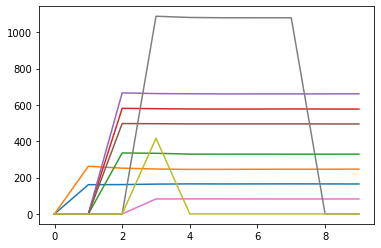

In [ ]:
for i in range(9):
    plt.plot(p[:, i])